In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import model_from_json
import pickle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Depression_EEG.csv to Depression_EEG.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Depression_EEG_cleaned.csv to Depression_EEG_cleaned.csv


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv('Depression_EEG.csv')

# Method 1: Remove rows with any null values
df_cleaned = df.dropna()

# Method 2: Fill null values with the mean of the column
df_filled = df.fillna(df.mean())

# Method 3: Interpolation (fill using neighboring values)
df_interpolated = df.interpolate()

# Save the cleaned dataset
df_cleaned.to_csv('Depression_EEG_cleaned.csv', index=False)

In [ ]:
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict, average='macro') * 100
    r = recall_score(testY, predict, average='macro') * 100
    f = f1_score(testY, predict, average='macro') * 100
    a = accuracy_score(testY, predict) * 100
    conf_matrix = confusion_matrix(testY, predict)

    print(f"{algorithm} Accuracy    : {a}")
    print(f"{algorithm} Precision   : {p}")
    print(f"{algorithm} Recall      : {r}")
    print(f"{algorithm} FScore      : {f}\n")

    labels = ['Normal', 'Depressed']
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", fmt="g")
    ax.set_ylim([0, 2])
    plt.title(f"{algorithm} Confusion Matrix")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

Number of samples: 2479, Number of features: 988
Reshaped data into: (2479, 38, 26, 1)
Resized data shape: (2479, 32, 32)
RGB data shape: (2479, 32, 32, 3)
Categorical labels shape: (2479, 3)
Train data shape: (1983, 32, 32, 3), Train labels shape: (1983, 3)
Test data shape: (496, 32, 32, 3), Test labels shape: (496, 3)
Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 149s 463ms/step - accuracy: 0.5843 - loss: 0.9344 - val_accuracy: 0.3649 - val_loss: 1.3188
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 71s 375ms/step - accuracy: 0.7659 - loss: 0.5307 - val_accuracy: 0.6855 - val_loss: 0.7316
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 48s 385ms/step - accuracy: 0.8411 - loss: 0.4217 - val_accuracy: 0.8589 - val_loss: 0.4588
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 80s 371ms/step - accuracy: 0.8841 - loss: 0.3304 - val_accuracy: 0.8891 - val_loss: 0.3959
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 373ms/step - accuracy: 0.8971 - loss: 0.2936 - val_accuracy: 0.8891 - val_loss: 0.6822
Epoch 6/10
124/124 ━━━

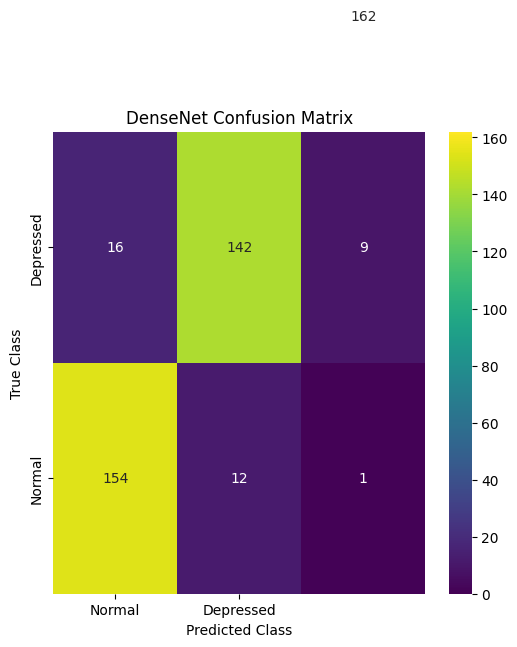

In [ ]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

# Load your dataset (replace with your actual loading method)
# df = pd.read_csv('your_dataset.csv')
# Assuming the dataset is loaded into X and y
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values    # Labels

# Scale the data (e.g., using StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data (number of samples, height, width, channels)
num_samples, num_features = X_scaled.shape
height, width = 38, 26  # Original reshape dimensions

# Check that num_features can be reshaped correctly
print(f"Number of samples: {num_samples}, Number of features: {num_features}")

# Ensure the total number of features is equal to height * width
if num_features != height * width:
    raise ValueError(f"Cannot reshape: {num_features} != {height * width}")

# Reshape the data into a 4D array
X_reshaped = X_scaled.reshape(-1, height, width, 1)
print(f"Reshaped data into: {X_reshaped.shape}")

# Resize images to 32x32
X_resized = np.array([cv2.resize(image.squeeze(), (32, 32)) for image in X_reshaped])
print(f"Resized data shape: {X_resized.shape}")

# Convert grayscale images to 3 channels
X_resized_rgb = np.repeat(X_resized[..., np.newaxis], 3, axis=-1)
print(f"RGB data shape: {X_resized_rgb.shape}")

# Convert labels to categorical format
y_categorical = to_categorical(y)
print(f"Categorical labels shape: {y_categorical.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resized_rgb, y_categorical, test_size=0.2, random_state=42)
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

# Build DenseNet model
densenet_base = DenseNet121(include_top=False, input_shape=(32, 32, 3), weights=None)

model = Sequential()
model.add(densenet_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')
predict =model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("DenseNet", predict, testY)
